In [854]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from imblearn.over_sampling import SMOTE 
%matplotlib inline
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [855]:
# Setting up Spotify API
import spotipy
import spotipy.util as util
from spotipy import oauth2
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import os

# Putting spotify credentials
os.environ['SPOTIPY_CLIENT_ID'] ='3a296280058f458d881e4caf58ff630f'
os.environ['SPOTIPY_CLIENT_SECRET'] ='2a815b9a6d974667be04307685c3215f'
os.environ['SPOTIPY_REDIRECT_URI'] ='http://localhost:7777/callback'

username = 'pvinqu86bwvr33t8tydnxdmh9'


scope = "user-read-private, streaming, playlist-read-collaborative, user-library-read,user-read-email, playlist-read-private, user-read-playback-position, user-library-modify, user-follow-read, user-read-currently-playing, user-follow-modify, playlist-modify-private, user-modify-playback-state, playlist-modify-public, app-remote-control, user-top-read, user-read-playback-state, user-read-recently-played,"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [856]:
df_top = pd.read_csv("my_spotify_data_with_top_tracks.csv")
df_liked = pd.read_csv("my_spotify_data_with_liked_tracks.csv")

In [857]:
df_top.favorite.value_counts()

0    1338
1      50
Name: favorite, dtype: int64

In [858]:
df_liked.favorite.value_counts()

0    1341
1      50
Name: favorite, dtype: int64

## Decision Tree Classifier model using TOP tracks

##### Since the dataset is imbalanced, I decided to use random oversampling.

In [859]:
# Shuffle your dataset 
shuffle_df1 = df_top.sample(frac=1)

# Define a size for your train set 
train_size1 = int(0.8 * len(df_top))

# Split dataset 
train_set1 = shuffle_df1[:train_size1]
test_set1 = shuffle_df1[train_size1:]

In [860]:
# Training data sets
X1 = train_set1.drop(columns=['favorite', 'track_id'])
y1 = train_set1.favorite
# Test datasets
X1_test = test_set1.drop(columns=['favorite', 'track_id'])
y1_test = test_set1['favorite']

y1.value_counts()

0    1072
1      38
Name: favorite, dtype: int64

In [861]:
# Oversampling the favorite songs to train classification model.
oversample = SMOTE()
X1_train, y1_train = oversample.fit_resample(X1, y1)

In [862]:
# y_train = y
y1_train.value_counts()

0    1072
1    1072
Name: favorite, dtype: int64

In [863]:
y1_test.value_counts()

0    266
1     12
Name: favorite, dtype: int64

In [864]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15, 20, 25, 30, 40],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X1_train, y1_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 25}

In [865]:
# Decision Tree Classifier
dt1 = DecisionTreeClassifier(max_depth=30).fit(X1_train, y1_train)
dt1_scores = cross_val_score(dt1, X1_train, y1_train, cv=10, scoring="f1")
np.mean(dt1_scores)

0.9350257587382135

In [866]:
# Building a pipeline to use on regular data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe1 = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=40))
pipe1.fit(X1_train, y1_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('dt', DecisionTreeClassifier(max_depth=30))])

pipe1.score(X1_test, y1_test)

0.9028776978417267

In [851]:
#plot_confusion_matrix(dt1, X1_test, y1_test)

In [867]:
# Function to create new playlist
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)
# Creating a new playlist   
create_playlist(sp, username, 'New Jams by Sumiya', 'This playlist was created using Decision Tree Classifier')

In [868]:
# Predicting if a song is a favorite
prob_preds1 = pipe1.predict_proba(df_top.drop(['favorite','track_id'], axis=1))
prediction1 = [1 if prob_preds1[i][1] == 1.0 else 0 for i in range(len(prob_preds1))]
df_top['prediction'] = prediction1

# Function to find the playlist ID of the most recently made playlist so we can add songs to it later
def find_recent_playlist_id(sp, username):
    #Getting all the playlists data
    playlists = sp.user_playlists(username)
    #Getting ID of latest playlist
    return playlists['items'][0]['id']

# Function to add selected songs to playlist
def add_tracks_playlist(sp, username, playlist_id, playlist_tracks):
    results = []
    results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[0:len(playlist_tracks)])

# Get the most recently made playlist ID
latest_playlist_id = find_recent_playlist_id(sp, username)
        
# Selecting IDs of predicted songs
recommended_tracks1 = df_top.loc[df_top['prediction']  == 1]['track_id']

# Check whether recommendation is already in user's top tracks
recommended_tracks1 = recommended_tracks1[recommended_tracks1.isin((df_top[df_top['favorite'] == 1].track_id)) == False]

#Add predicted tracks to the playlist
add_tracks_playlist(sp, username, latest_playlist_id, recommended_tracks)

## Decision Tree Classifier model using LIKED tracks

In [790]:
# Shuffle your dataset 
shuffle_df2 = df_liked.sample(frac=1)

# Define a size for your train set 
train_size2 = int(0.8 * len(df_liked))

# Split dataset 
train_set2 = shuffle_df2[:train_size1]
test_set2 = shuffle_df2[train_size1:]

In [791]:
# Training data sets
X2 = train_set2.drop(columns=['favorite', 'track_id'])
y2 = train_set2.favorite
# Test datasets
X2_test = test_set2.drop(columns=['favorite', 'track_id'])
y2_test = test_set2['favorite']

y2.value_counts()

0    1072
1      38
Name: favorite, dtype: int64

In [792]:
# Oversampling the favorite songs to train classification model.
oversample = SMOTE()
X2_train, y2_train = oversample.fit_resample(X2, y2)

In [793]:
# y_train = y
y2_train.value_counts()

0    1072
1    1072
Name: favorite, dtype: int64

In [794]:
y2_test.value_counts()

0    269
1     12
Name: favorite, dtype: int64

In [795]:
# Decision Tree Classifier
dt2 = DecisionTreeClassifier(max_depth=30).fit(X2_train, y2_train)
dt2_scores = cross_val_score(dt2, X2_train, y2_train, cv=10, scoring="f1")
np.mean(dt2_scores)

0.9150957539896216

In [796]:
# Building a pipeline to use on regular data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe2 = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=30))
pipe2.fit(X2_train, y2_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('dt', DecisionTreeClassifier(max_depth=30))])

pipe2.score(X2_test, y2_test)

0.8434163701067615

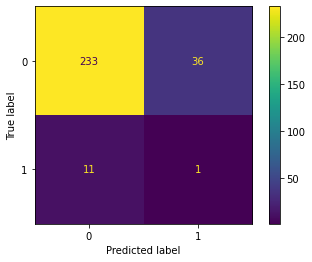

In [797]:
plot_confusion_matrix(dt2, X2_test, y2_test)

In [798]:
# Creating a new playlist   
create_playlist(sp, username, 'New jams by Sumiya based on Liked songs', 'This playlist was created using python! Decision tree classifier model was trained on LIKED songs data')

In [799]:
# Predicting if a song is a favorite
prob_preds2 = pipe2.predict_proba(df_liked.drop(['favorite','track_id'], axis=1))
prediction2 = [1 if prob_preds2[i][1] == 1.0 else 0 for i in range(len(prob_preds2))]
df_liked['prediction'] = prediction2

# Get the most recently made playlist ID
latest_playlist_id = find_recent_playlist_id(sp, username)
        
# Selecting IDs of predicted songs
recommended_tracks2 = df_liked.loc[df_liked['prediction']  == 1]['track_id']

# Check whether recommendation is already in user's top tracks
recommended_tracks2 = recommended_tracks2[recommended_tracks2.isin((df_liked[df_liked['favorite'] == 1].track_id)) == False]

#Add predicted tracks to the playlist
add_tracks_playlist(sp, username, latest_playlist_id, recommended_tracks2)